## Animal Crossing/ Doom Classifier
This classifier is a fun project I picked up to gain some practical ML experience. This project is based off of [tensorflow docs](https://www.tensorflow.org/tutorials/images/transfer_learning) aimed at transfer learning.  

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [32]:
data_dir = 'Data'

In [33]:
batch_size = 16
img_height = 224
img_width = 224

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1597 files belonging to 2 classes.
Using 1118 files for training.


In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1597 files belonging to 2 classes.
Using 319 files for validation.


In [36]:
class_names = train_ds.class_names
print(class_names)

['animal_crossing', 'doom']


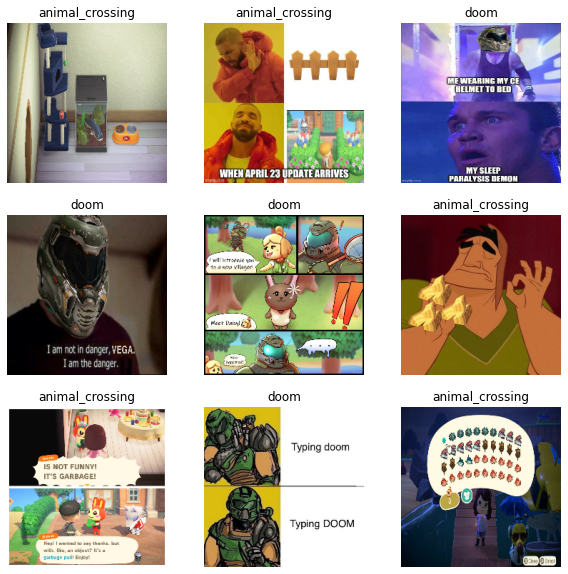

In [37]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [38]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [39]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of training batches: 70
Number of validation batches: 16
Number of test batches: 4


## Autotune Optimization
Autotune optimization is done for non-blocking I/O.  This allows training to occur while data is being loaded and vice-versa. More information can be read [here](https://www.tensorflow.org/guide/data_performance).

In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation
This dataset is quite small, so data augmentation is very important for this model to improve.

In [41]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

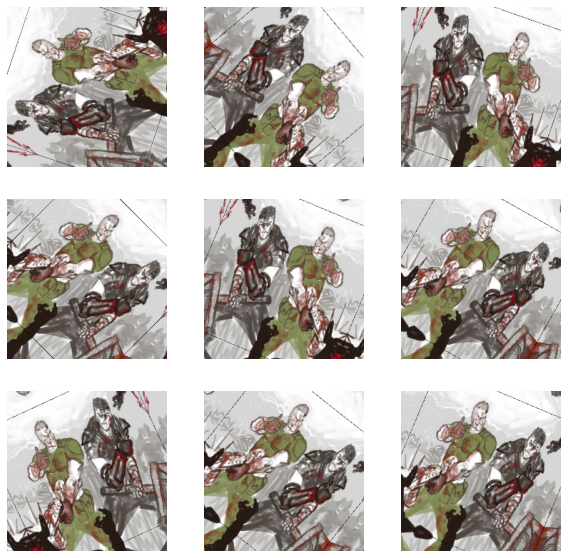

In [42]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [43]:
#Rescaling
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## MobileNet_v2
We will be using the MobileNet_v2 infrastructure because it is a very powerful network pre-trained on a huge amount of data with 1000 different classes. We need to chooes which layer to use for feature extraction, and typicaly the top layer is not very good because it is too specific and not very useful. More info on this [here](https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets).

In [45]:
IMG_SHAPE = (img_height, img_width) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [46]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


In [78]:
base_model.trainable = False

In [79]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [80]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [81]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [82]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [83]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [84]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0   

In [85]:
len(model.trainable_variables)

2

In [86]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(validation_dataset)

16/16 [==============================] - 15s 492ms/step - loss: 0.8013 - accuracy: 0.5037


In [87]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.83
initial accuracy: 0.49


In [88]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
70/70 [==============================] - 71s 918ms/step - loss: 0.7841 - accuracy: 0.5680 - val_loss: 0.5571 - val_accuracy: 0.6941
Epoch 2/15
70/70 [==============================] - 66s 884ms/step - loss: 0.6333 - accuracy: 0.6530 - val_loss: 0.4374 - val_accuracy: 0.8235
Epoch 3/15
70/70 [==============================] - 67s 902ms/step - loss: 0.5147 - accuracy: 0.7147 - val_loss: 0.3723 - val_accuracy: 0.8471
Epoch 4/15
70/70 [==============================] - 63s 852ms/step - loss: 0.4615 - accuracy: 0.7844 - val_loss: 0.3520 - val_accuracy: 0.8588
Epoch 5/15
70/70 [==============================] - 64s 866ms/step - loss: 0.4189 - accuracy: 0.8014 - val_loss: 0.3326 - val_accuracy: 0.8431
Epoch 6/15
70/70 [==============================] - 64s 859ms/step - loss: 0.3757 - accuracy: 0.8193 - val_loss: 0.3004 - val_accuracy: 0.8902
Epoch 7/15
70/70 [==============================] - 70s 955ms/step - loss: 0.3543 - accuracy: 0.8363 - val_loss: 0.3065 - val_accuracy: 0.8941

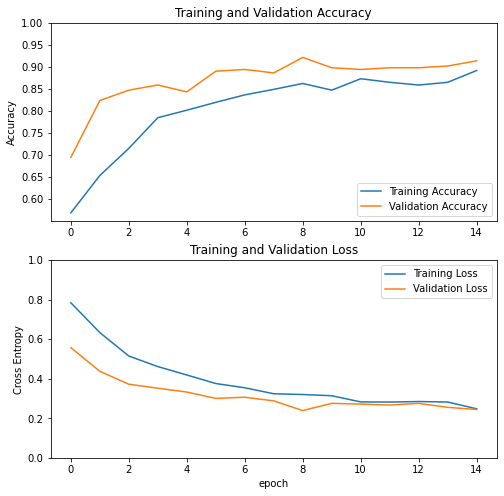

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning
The weights of the pre-trained model were not changed at all, and so fine tuning these weights to our training set may have a [positive affect](https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning) on the accuracy of the model.

In [90]:
base_model.trainable = True

In [91]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [92]:
#As you are training a much larger model and want to readapt the pretrained weights, 
#it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/20),
              metrics=['accuracy'])

In [93]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0   

In [94]:
len(model.trainable_variables)

56

In [95]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 15/30
70/70 [==============================] - 74s 950ms/step - loss: 0.2991 - accuracy: 0.8641 - val_loss: 0.2576 - val_accuracy: 0.9059
Epoch 16/30
70/70 [==============================] - 70s 941ms/step - loss: 0.2370 - accuracy: 0.8952 - val_loss: 0.2294 - val_accuracy: 0.9176
Epoch 17/30
70/70 [==============================] - 69s 932ms/step - loss: 0.2230 - accuracy: 0.8964 - val_loss: 0.2730 - val_accuracy: 0.8980
Epoch 18/30
70/70 [==============================] - 69s 931ms/step - loss: 0.2088 - accuracy: 0.8996 - val_loss: 0.3468 - val_accuracy: 0.8706
Epoch 19/30
70/70 [==============================] - 70s 944ms/step - loss: 0.2156 - accuracy: 0.9084 - val_loss: 0.2487 - val_accuracy: 0.9137
Epoch 20/30
70/70 [==============================] - 69s 929ms/step - loss: 0.2094 - accuracy: 0.9221 - val_loss: 0.2788 - val_accuracy: 0.9137
Epoch 21/30
70/70 [==============================] - 69s 932ms/step - loss: 0.1981 - accuracy: 0.9081 - val_loss: 0.2837 - val_accuracy:

In [96]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

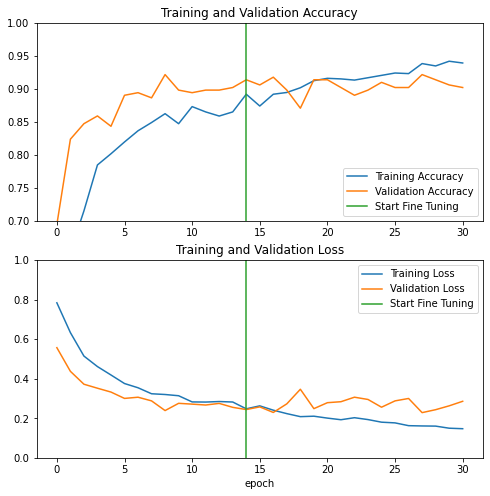

In [97]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [98]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 7s 576ms/step - loss: 0.3413 - accuracy: 0.8750
Test accuracy : 0.875


Predictions:
 [1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0]
Labels:
 [1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1]


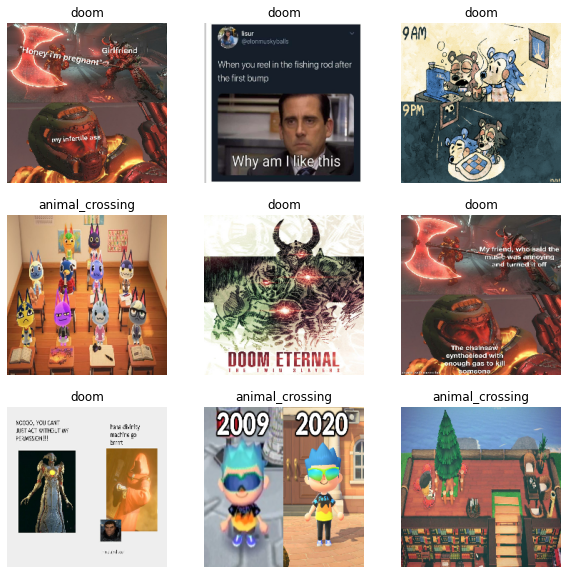

In [184]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

[1, 3, 23, 39, 42, 45, 46, 47, 56]


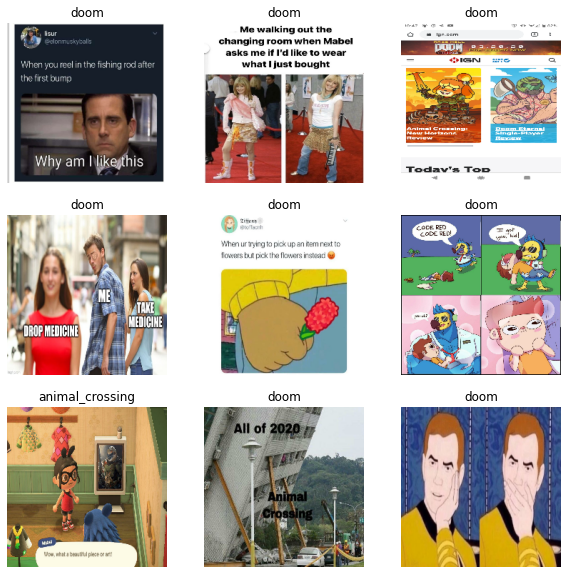

In [214]:
# Get all predictions and labels
final_images = []
final_predictions = []
final_labels = []

for x in test_dataset.as_numpy_iterator():
    image_batch, label_batch = x
    predictions = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    final_images.append(image_batch)
    final_predictions = np.append(final_predictions,predictions.numpy())
    final_labels = np.append(final_labels, label_batch)
    
final_images = np.reshape(final_images, (4*16,224,224,3))

#Check which images were difficult for the model
Mislabeled = [x for x in range(len(final_predictions)) if final_predictions[x] != final_labels[x]]
print(Mislabeled)
plt.figure(figsize=(10, 10))
for i in range(min(9,len(Mislabeled))):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(final_images[Mislabeled[i]].astype("uint8"))
  plt.title(class_names[final_predictions[Mislabeled[i]].astype("uint8")])
  plt.axis("off")

## Future Works
I think the model can be made slightly more accurate. The validation accuracy is not quite smooth from epoch to epoch so I think there could be some work done to regularize the model a little bit better. Overall I am quite happy, I believe there is a not so insignificant amount of memes that would be hard for even a human to distinguish whether it is a doom or animal crossing meme because there are a few memes that include both doom and animal crossing characters. A future improvement may be to include the caption as extra information, however I am not sure how much this will improve things. 

There is also a fair amount of memes that are text heavy and may benefit from a different model other than a MobileNet CNN. 
